In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

# .py
%load_ext autoreload
%autoreload 2
import bounded_alphas, costs, model, weighted_costs, weighted_bounded_alphas

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


running model
getting cost from nweek ahead
getting bounded alphas ...
done getting alphas ...
getting cost from nweek ahead
getting bounded alphas ...
done getting alphas ...


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

In [3]:
all_weather = pd.read_csv("weather01-16.csv")

In [4]:
cm_weather = all_weather[all_weather.stn_name == "Chiang Mai"]
cm_weather.index = pd.DatetimeIndex(cm_weather.date)
mask = (cm_weather.index > "2003") & (cm_weather.index < "2016")
cm_weather = cm_weather[mask]

provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)
cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])

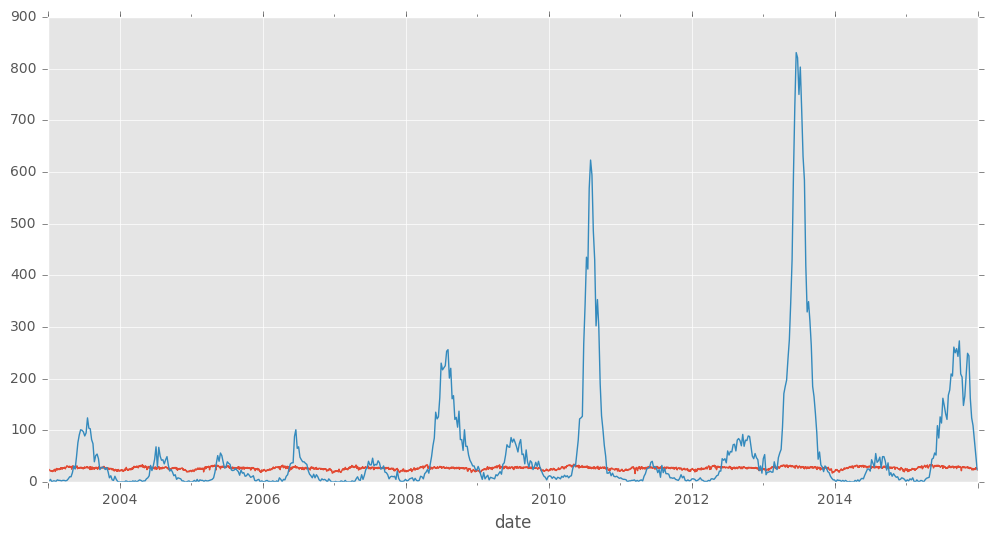

In [5]:
plt.figure(figsize=(12,6))
cm_weather.meantemp.plot()
cm_dengues_df.cases[:-52].plot()

In [6]:
# cm_weather.tail()

In [7]:
cm_avg_weather = cm_weather[['avgrh','dday','maxtemp','meantemp','mintemp','rain']].resample('W').mean()


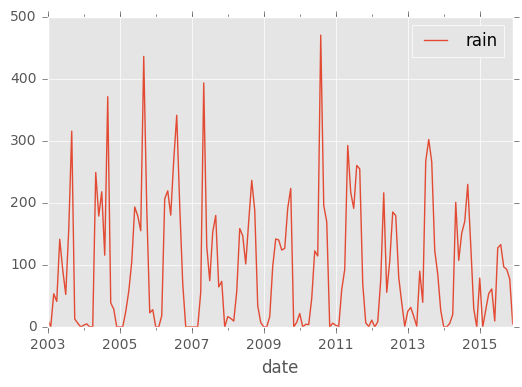

In [8]:
cm_weather[['rain']].resample('M').sum().plot()

In [9]:
cm_dengues_weather = pd.concat([cm_avg_weather,cm_dengues_df[:-52]],axis=1)

In [11]:
cm_dengues_weather_split = split_data(cm_dengues_weather)
cm_dengues_train, cm_dengues_test = cm_dengues_weather_split[0], cm_dengues_weather_split[1]

In [13]:
%%time

lg = 16
half_trimester = 9 # static

def cost(w):
    
    ret = 0
    for i in range(len(cm_dengues_train)-(lg+1)):
#         real_case = cm_dengues_df[:-52].cases[i+1]
        cases_for_prediction = cm_dengues_train.cases[i:i+lg]
        nth_week = i + lg
        mean_temperatures = cm_dengues_train.meantemp[i:i+half_trimester]
                                #guess(w, nth_week, cases_for_prediction, degree, rain)
        predicted_case = model.guess(
            w,
            nth_week,
            cases_for_prediction,
            mean_temperatures)
        real_case = cm_dengues_train.cases[i+(lg+1)] + 1
        sigma_sq = real_case + 1
        
        ret += ((real_case - predicted_case)**2)/float(sigma_sq)
    return ret

# arr = [1.]*(lg+1+half_trimester+1+2)
# w = minimize(cost,arr)

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 20 µs


In [14]:
# w.x

In [15]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def plot_all_predictions(LAG, real, province, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "%s's Dengue Prediction"%province
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(cm_dengues_df.cases,cm_dengues_train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend()
#     plt.savefig("13-lags-14-weeks-weather-chiangmai.png")
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

In [16]:
predictions = []
for i in range(len(cm_dengues_weather)-(lg+1)):
#     print cm_dengues_weather.meantemp[i]
    print i,i+half_trimester
    predicted = model.guess(
        w.x,
        i+(lg+1),
        cm_dengues_weather.cases[i:i+lg],
        cm_dengues_weather.meantemp[i:i+half_trimester])
    predictions.append(predicted)

# plt.figure(figsize=(12,6))
# plt.plot(range(26,len(predictions)+26),predictions,label="prediction")
# plt.plot(range(len(cm_dengues_weather)),cm_dengues_weather.cases)
# plt.legend()

0 9


NameError: name 'w' is not defined

In [107]:
all_weather = pd.read_csv("weather01-16.csv")
all_weather.index = pd.DatetimeIndex(all_weather.date)
mask = (all_weather.index > "2003") & (all_weather.index < "2016")
all_weather = all_weather.drop(['date'],axis=1)
all_weather = all_weather[mask]
# all_weather_df = all_weather.resample('W').mean()

all_dengues = pd.read_csv("all-dengues.csv")
all_dengues.index = pd.DatetimeIndex(all_dengues.date)
all_dengues = all_dengues.drop(['date','date.1'],axis=1)
all_dengues = all_dengues.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])

In [108]:
all_avg_weather = all_weather[['avgrh','dday','maxtemp','meantemp','mintemp','rain']].resample('W').mean()[:-1]
all_dengues_weather = pd.concat([all_avg_weather,all_dengues_df[:-53]],axis=1)

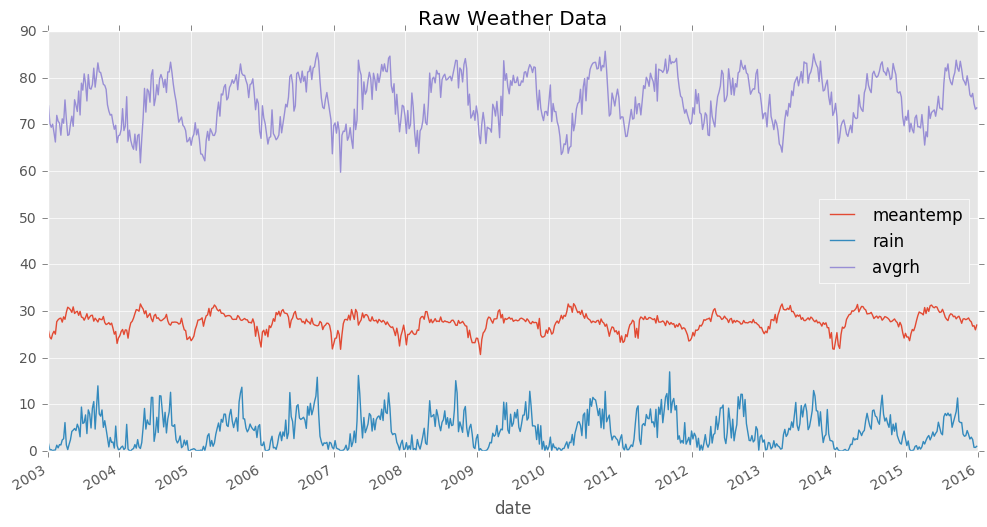

In [86]:
xs = [str(i) for i in range(2003,2017)]
plt.figure(figsize=(12,6))
all_avg_weather.meantemp.plot(x_compat=True,xticks=xs)
all_avg_weather.rain.plot(x_compat=True,xticks=xs)
all_avg_weather.avgrh.plot(x_compat=True,xticks=xs)
plt.legend(loc='best')
plt.title('Raw Weather Data')
# plt.savefig('raw-weather-data.pdf',dpi = 300, bbox_inches='tight')

1454.86135693 1265.59764957
27.6629356152 1.85853616689
4.46563306712 3.43690521913
75.1291647298 5.42843333961


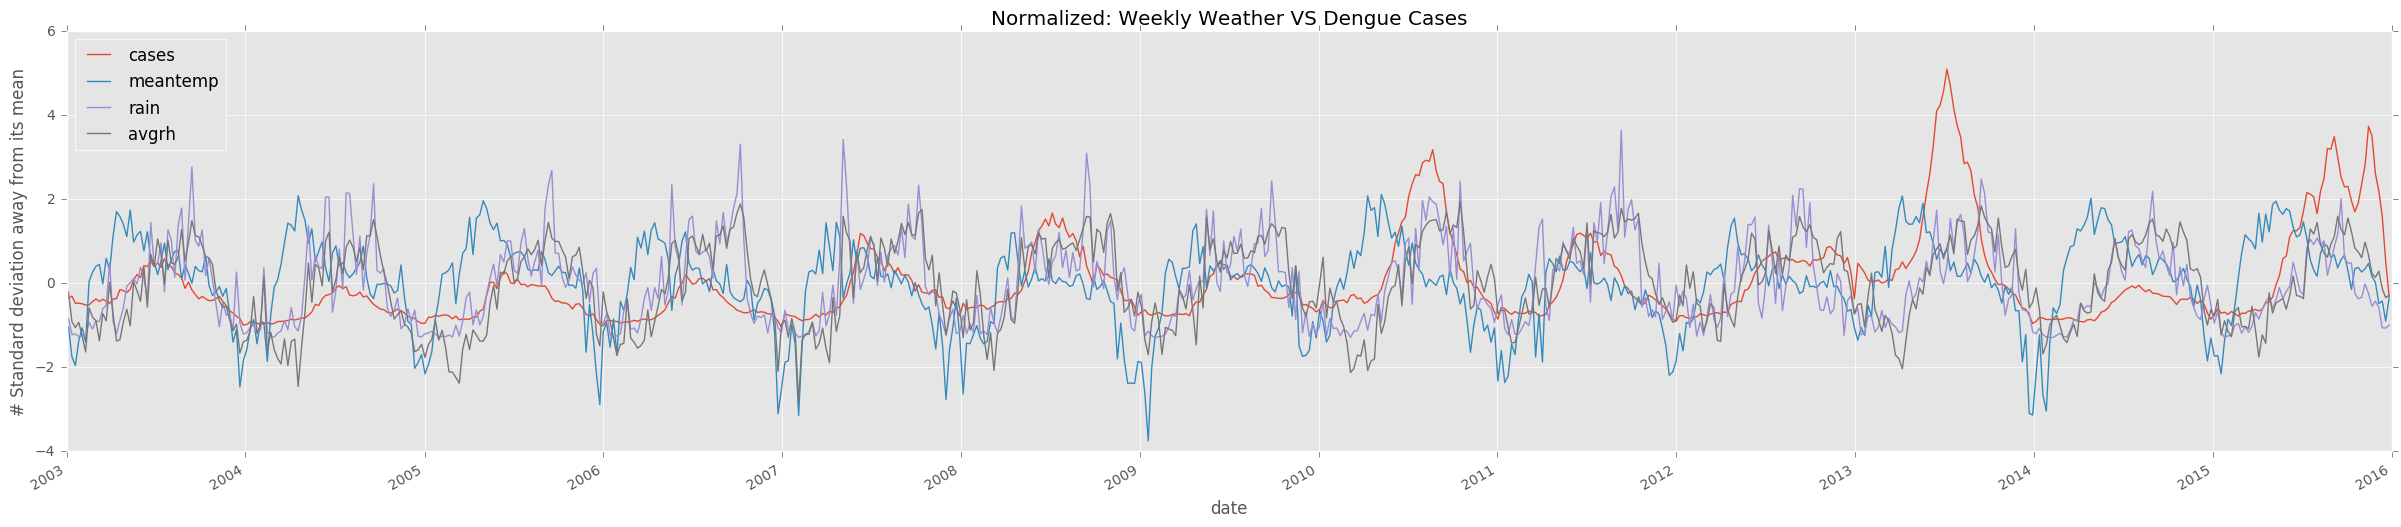

In [119]:
nm_all_dengue = (all_dengues_weather.cases - all_dengues_weather.cases.mean()) / all_dengues_weather.cases.std()
nm_all_temp = (all_avg_weather.meantemp - all_avg_weather.meantemp.mean()) / all_avg_weather.meantemp.std()
nm_all_rain = (all_avg_weather.rain - all_avg_weather.rain.mean()) / all_avg_weather.rain.std()
nm_all_avgrh = (all_avg_weather.avgrh - all_avg_weather.avgrh.mean()) / all_avg_weather.avgrh.std()

print all_dengues_weather.cases.mean(), all_dengues_weather.cases.std()
print all_avg_weather.meantemp.mean(),all_avg_weather.meantemp.std()
print all_avg_weather.rain.mean(),all_avg_weather.rain.std()
print all_avg_weather.avgrh.mean(),all_avg_weather.avgrh.std()

xs = [str(i) for i in range(2003,2017)]
plt.figure(figsize=(30,6))

nm_all_dengue.plot(x_compat=True,xticks=xs)
nm_all_temp.plot(x_compat=True,xticks=xs)
nm_all_rain.plot(x_compat=True,xticks=xs)
nm_all_avgrh.plot(x_compat=True,xticks=xs)
plt.legend(loc='best')
plt.ylabel('# Standard deviation away from its mean')
plt.title('Normalized: Weekly Weather VS Dengue Cases')
# plt.savefig('norm-weather-dengue-data.pdf',dpi = 300, bbox_inches='tight')

In [50]:
yr = [str(i) for i in range(2003,2016)]
tmp = []
for i in range(len(yr)-1):
    mask = (all_dengues_weather.index > yr[i]) & (all_dengues_weather.index < yr[i+1])
    tmp.append(all_dengues_weather[mask])

In [51]:
train_weekly_cases = []
train_weekly_meantemp = []
train_weekly_rain = []
train_weekly_avgrh = []
for data in tmp:
    train_weekly_cases.append(data.cases)
    train_weekly_meantemp.append(data.meantemp)
    train_weekly_rain.append(data.rain)
    train_weekly_avgrh.append(data.avgrh)

In [67]:
train_weekly_cases = np.array(train_weekly_cases)
train_weekly_meantemp = np.array(train_weekly_meantemp)
train_weekly_rain = np.array(train_weekly_rain)
train_weekly_avgrh = np.array(train_weekly_avgrh)

In [113]:
avg_train_weekly_cases = sum(train_weekly_cases) / 13.
norm_train_weekly_cases = pd.Series((avg_train_weekly_cases - avg_train_weekly_cases.mean())/avg_train_weekly_cases.std())

avg_train_weekly_meantemp = sum(train_weekly_meantemp) / 13.
norm_train_weekly_meantemp = pd.Series((avg_train_weekly_meantemp - avg_train_weekly_meantemp.mean())/avg_train_weekly_meantemp.std())
print 'mean_temp', avg_train_weekly_meantemp.mean(), avg_train_weekly_meantemp.std()

avg_train_weekly_rain = sum(train_weekly_rain) / 13.
norm_train_weekly_rain = pd.Series((avg_train_weekly_rain - avg_train_weekly_rain.mean())/avg_train_weekly_rain.std())
print 'rain', avg_train_weekly_rain.mean(), avg_train_weekly_rain.std()

avg_train_weekly_avgrh = sum(train_weekly_avgrh) / 13.
norm_train_weekly_avgrh = pd.Series((avg_train_weekly_avgrh - avg_train_weekly_avgrh.mean())/avg_train_weekly_avgrh.std())
print 'avgrh', avg_train_weekly_avgrh.mean(),avg_train_weekly_avgrh.std()

mean_temp 25.4771405589 1.45251918534
rain 4.18530415562 2.62510097938
avgrh 69.3659145576 4.34592926464


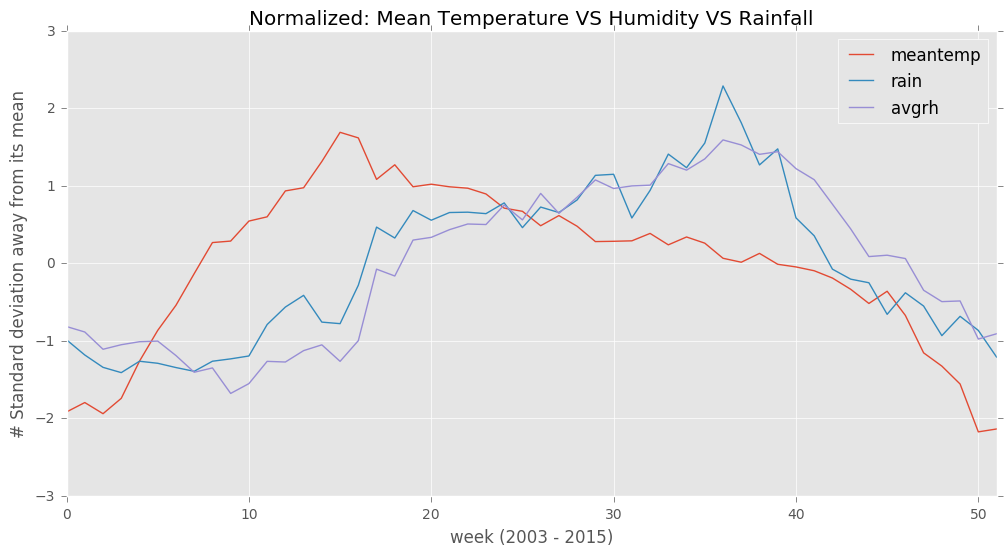

In [116]:
plt.figure(figsize=(12,6))
# plt.plot(norm_train_weekly_cases,label='cases')
plt.plot(norm_train_weekly_meantemp,label='meantemp')
plt.plot(norm_train_weekly_rain,label='rain')
plt.plot(norm_train_weekly_avgrh,label='avgrh')
plt.xlim(0,51)
plt.title("Normalized: Mean Temperature VS Humidity VS Rainfall")
plt.ylabel('# Standard deviation away from its mean')
plt.xlabel('week (2003 - 2015)')
plt.legend()
# plt.savefig('average-weekly-distribution-weather.pdf')

In [28]:
w_case = 7
temperature = 2
rainfall = 2
humid = 2

a = [1.]*w_case
b = [2,2,3,3,4,4]
a = np.append(a,b)
print a[:w_case]
print a[w_case:w_case+temperature]
print a[w_case+temperature:w_case+temperature+rainfall]

[ 1.  1.  1.  1.  1.  1.  1.]
[ 2.  2.]
[ 3.  3.]


In [30]:
all_w = [1,1,1,1,1,1,1,2,2,3,3,4,4]
case = all_w[:w_case]
temp = all_w[w_case:w_case+temperature]
rain = all_w[w_case+temperature:w_case+temperature+rainfall]
hum = all_w[w_case+temperature+rainfall:w_case+temperature+rainfall+humid]
print case
print temp
print rain
print hum

[1, 1, 1, 1, 1, 1, 1]
[2, 2]
[3, 3]
[4, 4]


In [35]:
model.guess([1.]*29,0,[1.]*16,[0.]*9) # lag = 16; week = 9

31.950876435659506